# Recognize epileptic seizures in EEG

### Theoretical notes on DFT

$$y[k] = \sum_{n=0}^{N-1} x[n] e^{-i \frac{2 \pi}{N} n k}$$

$$x[n] = \frac{1}{N} \left( \sum_{k=0}^{N-1} y[k] e^{i \frac{2 \pi}{N} n k} \right)$$
* DFT takes a signal in temporal domain $[0;  N*T_{sampling}]$  and represents it in frequency domain $[0; F_{sampling}]$.
* *Intuition*:
    * The term $e^{-i \frac{2 \pi}{N}}$ defines an elementary angle of $\frac{2\pi}{N}$ radians on the unit circle and its integer powers are multiples of the angle.
    * To reveal harmonics hidden in a signal we sum its sample points weighted with some vectors from the unit circle.
    * The vectors will "rotate" as we go from one sample point to another.
    * We will try all possible rotation frequencies $f \in \left\{0, \frac{F_{sampling}}{N}, \frac{2 F_{sampling}}{N}, ..., \frac{(N-1)F_{sampling}}{N} \right\}$.
    * When the rotation frequency will match an inherent frequency of the signal, the weighted sum will have large absolute values.
* In practice the time series is always real-valued. In this case it is enough to consider only the first half of the frequencies, because the second half will be symmetric to the first and thus will bring no new information.

### Prepare data subsets

In [1]:
from IPython.display import display, Markdown

import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = '../data'
labels = ('Z', 'O', 'N', 'F', 'S')

def read_set(code):
    with open(os.path.join(DATA_PATH, code + '.npy'), "rb") as f:
        return np.load(f)

subsets = [
    {'data': read_set(l), 'label': l}
    for l in labels
]

### Dataset

In [3]:
from scipy.fftpack import fft, fftfreq
from sklearn.preprocessing import LabelEncoder

t = 23.6
N = 4097
Fs = N / t
print(f"sampling frequency: {Fs:.1f} Hz")
print(f"sampling period: {1 / Fs:.3f} sec")


def get_fft_values(X, Fs, N):
    f_values = fftfreq(N, d=1 / Fs)[0:N//2]
    fft_values_ = fft(X)
    fft_values = 2.0/N * np.abs(fft_values_[:, 0:N//2])
    return f_values, fft_values


def prepare_dataset(subsets, fourier=False):
    xs = []
    for s in subsets:
        x = s['data']
        if fourier:
            _, x = get_fft_values(x, Fs, N)
        xs.append(x)
    features = np.concatenate(xs, axis=0)

    labels = np.concatenate([
        [s['label']] * len(s['data']) for s in subsets
    ], axis=0)

    label_encoder = LabelEncoder()
    label_encoder.fit_transform(labels)
    
    return features, labels, label_encoder

sampling frequency: 173.6 Hz
sampling period: 0.006 sec


### Classify EEG segments

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [5]:
def test_dataset(features, labels):
    model = RandomForestClassifier(random_state=0)
    scores = cross_val_score(
        model, features, labels, 
        scoring='accuracy', 
        cv=5, 
        n_jobs=-1,
    )
    print(f"CV accuracy: mu={np.mean(scores):.2f}, std={np.std(scores):.2f}")


def split_dataset(X, mask):
    return X[~mask], X[mask]

def show_confusion(X, y, test_mask):
    X, X_test = split_dataset(X, test_mask)
    y, y_test = split_dataset(y, test_mask)
    
    model = RandomForestClassifier(random_state=0)
    model.fit(X, y)

    y_pred = model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, labels=labels)
    cf_df = pd.DataFrame(cf_matrix, index=labels, columns=labels)
    sns.heatmap(cf_df, annot=True)
    plt.show()

In [6]:
X, y, _ = prepare_dataset(subsets)
Xf, yf, _ = prepare_dataset(subsets, fourier=True)

test_dataset(X, y)
test_dataset(Xf, yf)

CV accuracy: mu=0.65, std=0.03
CV accuracy: mu=0.83, std=0.03


#### Classify using initial signal values

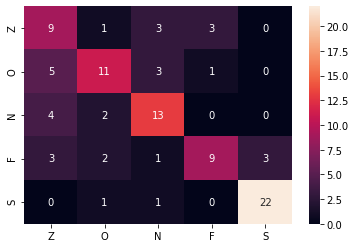

#### Classify using spectrum values

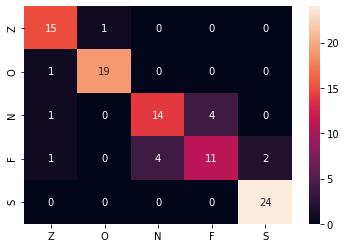

In [7]:
test_size = 0.2
test_mask = np.random.choice(2, size=len(y), p=[1-test_size, test_size]).astype(bool)

display(Markdown('#### Classify using initial signal values'))
show_confusion(X, y, test_mask)
display(Markdown('#### Classify using spectrum values'))
show_confusion(Xf, yf, test_mask)